In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
#import os 
#os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [3]:
%matplotlib notebook
import pandas as pd
import numpy as np
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from scipy.stats import gaussian_kde

import seaborn as sns
import matplotlib.pyplot as plt

# Preparing the data

In [12]:
# import the dataset
df_sample = pd.read_csv('basic_feature_dataset_3258rec_2022-11-13.csv')

# remove the bracket from the columns' values
df_sample['Arrival_date'] = df_sample['Arrival_date'].str.replace('[', '', regex=False)
df_sample['glcm_energy_std'] = df_sample['glcm_energy_std'].str.replace(']', '', regex=False)
# convert date column to datetime
#df_sample['Arrival_date'] = pd.to_datetime(df_sample['Arrival_date'])

# convert Arrival_time column
df_sample['Arrival_time'] = df_sample['Arrival_time'].str.replace('\'', '')
df_sample['Arrival_time'] = df_sample['Arrival_time'].str.strip()
#df_sample['Arrival_time'] = pd.to_datetime(df_sample['Arrival_time'],format= '%H:%M:%S' ).dt.time

# convert columns to correct types
df_sample['glcm_energy_std'] = df_sample['glcm_energy_std'].astype(float)
df_sample['Europ._waste_code'] = df_sample['Europ._waste_code'].astype(str)
df_sample['Source_company'] = df_sample['Source_company'].astype(str)
df_sample['Contract_nb'] = df_sample['Contract_nb'].astype(str)
df_sample['Contract_pos'] = df_sample['Contract_pos'].astype(str)

In [13]:
len(df_sample)

3258

In [14]:
len(df_sample['Source_company'].unique())

54

In [15]:
df_sample.head()

,Arrival_date,Arrival_time,Europ._waste_code,Net_weight,Source_company,Contract_nb,Contract_pos,contourness_std_std,fall_direction_variation_abs,blobness_abs,homogeneity_std_std,glcm_homogeneity_std,glcm_contrast_std,glcm_energy_std
0,'2022-10-07T00:00:00',13:11:12,200301,23.64,88000232,75000445,80,17.189223,0.187071,0.321500,292.000000,0.087287,396.903969,0.029164
1,'2022-10-07T00:00:00',13:11:12,200301,23.64,88000232,75000445,80,21.410781,0.552424,0.448576,6296.590144,0.010464,211.241986,0.003259
2,'2022-10-07T00:00:00',13:11:12,200301,23.64,88000232,75000445,80,19.916188,0.569929,0.389721,7216.170149,0.012021,143.729393,0.004328
3,'2022-10-07T00:00:00',13:11:12,200301,23.64,88000232,75000445,80,20.673211,0.643507,0.568341,8908.540108,0.029918,223.720538,0.008325
4,'2022-10-07T00:00:00',12:05:54,191212,23.96,88000003,75000004,520,43.699064,0.501879,0.488950,16455.768358,0.006662,69.658903,0.002065


In [16]:
df_sample['time'] = df_sample['Arrival_date'] + df_sample['Arrival_time']

# TSNE

In [19]:
# Filter out the waste code
X = df_sample[[ 'contourness_std_std',
 'fall_direction_variation_abs',
 'blobness_abs',
 'homogeneity_std_std',
 'glcm_homogeneity_std',
 'glcm_contrast_std',
 'glcm_energy_std']]

y = df_sample['Europ._waste_code'] #old
# create dictionary of labels for the dropdown
label_dic = {
    'Arrival_date': df_sample['Arrival_date'].astype(str),
    'Arrival_time': df_sample['Arrival_time'].astype(str),
    'Europ_waste_code': df_sample['Europ._waste_code'],
    'Net_weight': df_sample['Net_weight'].astype(str),
    'Source_company': df_sample['Source_company'],
    'Contract_nb': df_sample['Contract_nb'],
    'Contract_pos': df_sample['Contract_pos'],
    'Time': df_sample['time']
} #new

# create pipeline
n_components = 2
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('tnse', TSNE(n_components, perplexity=50, learning_rate='auto', init='pca'))
])


Y = pipeline.fit_transform(X)

xy = np.vstack([Y[:, 0],Y[:, 1]])
color_gaussian = gaussian_kde(xy)(xy)
color_dic = {
    'Gaussian_kde': color_gaussian,
    'Europ_waste_code': df_sample['Europ._waste_code'],
    'Net_weight': df_sample['Net_weight'],
    'Source_company': df_sample['Source_company'],
    'Contract_nb': df_sample['Contract_nb'],
    'Contract_pos': df_sample['Contract_pos']
}

labels = df_sample['Europ._waste_code'] #new

nbins=300
k = gaussian_kde([Y[:, 0],Y[:, 1]])
xi, yi = np.mgrid[Y[:, 0].min():Y[:, 0].max():nbins*1j, Y[:, 1].min():Y[:, 1].max():nbins*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))

/Users/aliafs/opt/anaconda3/envs/general/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


# Plot the TSNE result

In [20]:
import ipywidgets as widgets

def label_viz(label='Europ_waste_code', color='Gausssian_kde'):
    
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.pcolormesh(xi, yi, zi.reshape(xi.shape), shading='auto', cmap=plt.cm.Greens)

    if color != 'Gaussian_kde':
        # Unique category labels
        color_labels = color_dic[color].unique()
        # List of RGB triplets
        rgb_values = sns.color_palette("Set2", len(color_labels))
        # Map label to RGB
        color_map = dict(zip(color_labels, rgb_values))
        c=color_dic[color].map(color_map)
        sc = plt.scatter(Y[:, 0], Y[:, 1], c=c, label=color_dic[color], s=15)
    else:
        c=color_dic[color]
        sc = plt.scatter(Y[:, 0], Y[:, 1], c=c, label=color_dic[color], cmap=plt.cm.Spectral, s=15)
    #sc = sns.scatterplot(x=Y[:, 0], y=Y[:, 1], cmap=plt.cm.Spectral, hue=color_dic[color_label],ax=ax)
    #sc = plt.scatter(Y[:, 0], Y[:, 1], c=color_dic[color_label], label=labels, cmap=plt.cm.Spectral) #,label = labels

    #names = np.array(list(y)) #old
    names = np.array(list(label_dic[label])) #new
    norm = plt.Normalize(1,4)
    cmap = plt.cm.RdYlGn

    annot = ax.annotate("", xy=(0,0), xytext=(20,20),textcoords="offset points",
                        bbox=dict(boxstyle="round", fc="w"),
                        arrowprops=dict(arrowstyle="->"))
    annot.set_visible(False)

    def update_annot(ind):
        pos = sc.get_offsets()[ind["ind"][0]]
        annot.xy = pos
        text = "{}".format("\n".join([names[n] for n in ind["ind"]])) #new
        annot.set_text(text)
        annot.get_bbox_patch().set_alpha(0.4)


    def hover(event):
        vis = annot.get_visible()
        if event.inaxes == ax:
            cont, ind = sc.contains(event)
            if cont:
                update_annot(ind)
                annot.set_visible(True)
                fig.canvas.draw_idle()
            else:
                if vis:
                    annot.set_visible(False)
                    fig.canvas.draw_idle()

    fig.canvas.mpl_connect("motion_notify_event", hover)
    #ax.legend(*sc.legend_elements())
    plt.show()

In [21]:
widgets.interact(label_viz, label=list(label_dic.keys()), color=list(color_dic.keys()))

interactive(children=(Dropdown(description='label', index=2, options=('Arrival_date', 'Arrival_time', 'Europ_w…

<function __main__.label_viz(label='Europ_waste_code', color='Gausssian_kde')>

In [7]:
from sklearn.decomposition import PCA

# Create pipeline for pca
pipeline_pca = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA())
])

In [8]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [9]:
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

Text(0.5, 1.0, 'Explained Variance Per Principal Component')

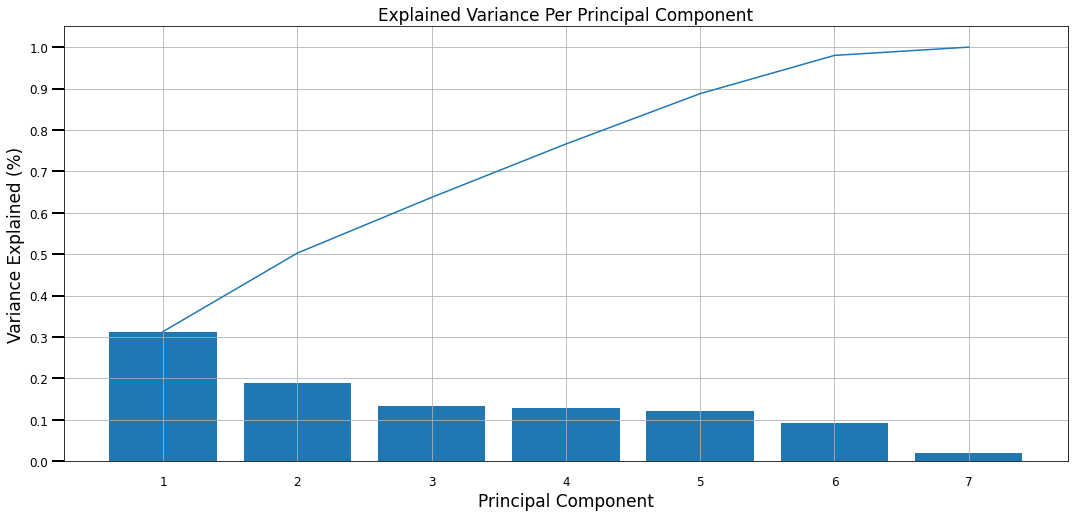

In [10]:
# Investigate the variance accounted for by each principal component.

num_components = len(pca.explained_variance_ratio_)
ind = np.arange(1, num_components+1)
var_ratio = pca.explained_variance_ratio_
cum_var_ratio = np.cumsum(var_ratio)

fig, ax = plt.subplots(figsize=(18, 8))
ax.bar(ind, var_ratio)
ax.plot(ind, cum_var_ratio)

ax.xaxis.set_tick_params(width=0, length=10, labelsize=12)
ax.set_xticks(np.arange(1, num_components+1, 1))
ax.yaxis.set_tick_params(width=2, length=12, labelsize=12)
ax.set_yticks(np.linspace(0, 1, num=11))

plt.grid()

ax.set_xlabel("Principal Component", fontsize=17)
ax.set_ylabel("Variance Explained (%)", fontsize=17)
plt.title('Explained Variance Per Principal Component', fontsize=17)

In [11]:
# Re-apply PCA to the data while selecting for number of components to retain.

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

In [12]:
def get_weights_sorted(component):
    # -----------------------------------------------------------
    # Function return a dictionary of features and their weights
    # sorted by weights for given component
    
    # Argument: index of intended component
    
    # return : dictionary contains feature and corresponding weights
    # -----------------------------------------------------------
    
    weights = pca.components_[component]
    features = list(X.columns)
    features_sorted = [feature for _, feature in sorted(zip(weights, features), reverse=True)]
    weights_sorted = sorted(weights, reverse=True)
    
    feat_dic = res = dict(zip(features_sorted, weights_sorted))

    return feat_dic

In [13]:
get_weights_sorted(0)

{'glcm_homogeneity_std': 0.6175728856590905,
 'glcm_energy_std': 0.56637346104152,
 'contourness_std_std': 0.29516533466248285,
 'glcm_contrast_std': 0.2640203080613029,
 'blobness_abs': 0.23437694216239296,
 'homogeneity_std_std': 0.2261680786862146,
 'fall_direction_variation_abs': -0.18684481485271454}

In [14]:
get_weights_sorted(1)

{'blobness_abs': 0.5516301382671859,
 'contourness_std_std': 0.1915741250691055,
 'glcm_energy_std': -0.1263318621732647,
 'glcm_homogeneity_std': -0.1361417500063476,
 'homogeneity_std_std': -0.2888442155599211,
 'glcm_contrast_std': -0.33163414599326113,
 'fall_direction_variation_abs': -0.6565798062789248}

In [15]:
pca_result_df = pd.DataFrame({'pca_1': X_pca[:,0], 'pca_2': X_pca[:,1], 'code': y})

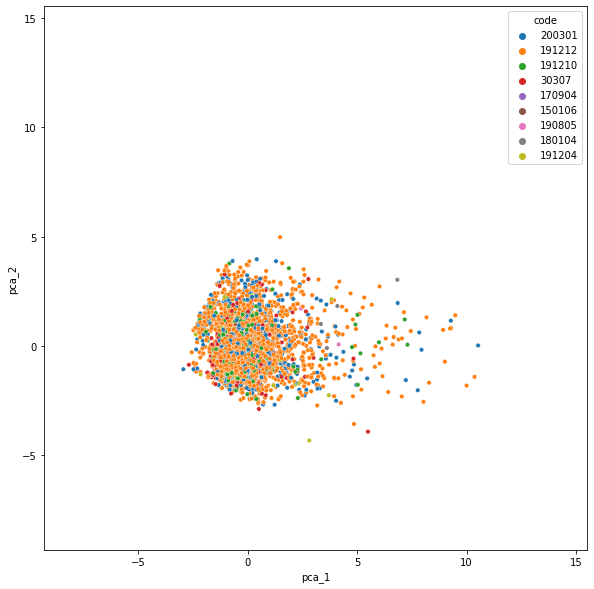

In [16]:
# Plot pca result
fig, ax = plt.subplots(1, figsize=(10, 10))
sns.scatterplot(x='pca_1', y='pca_2', data=pca_result_df, ax=ax, s=20, hue='code')
lim = (X_pca.min()-5, X_pca.max()+5)
ax.set_xlim(lim)
ax.set_ylim(lim)
ax.set_aspect('equal')

## Sample of the dataset

In [6]:
df_sample.head()

,Arrival_date,Arrival_time,Europ._waste_code,Net_weight,Source_company,Contract_nb,Contract_pos,contourness_std_std,fall_direction_variation_abs,blobness_abs,homogeneity_std_std,glcm_homogeneity_std,glcm_contrast_std,glcm_energy_std
0,2022-10-07,13:11:12,200301,23.64,88000232,75000445,80,17.189223,0.187071,0.321500,292.000000,0.087287,396.903969,0.029164
1,2022-10-07,13:11:12,200301,23.64,88000232,75000445,80,21.410781,0.552424,0.448576,6296.590144,0.010464,211.241986,0.003259
2,2022-10-07,13:11:12,200301,23.64,88000232,75000445,80,19.916188,0.569929,0.389721,7216.170149,0.012021,143.729393,0.004328
3,2022-10-07,13:11:12,200301,23.64,88000232,75000445,80,20.673211,0.643507,0.568341,8908.540108,0.029918,223.720538,0.008325
4,2022-10-07,12:05:54,191212,23.96,88000003,75000004,520,43.699064,0.501879,0.488950,16455.768358,0.006662,69.658903,0.002065


<IPython.core.display.Javascript object>


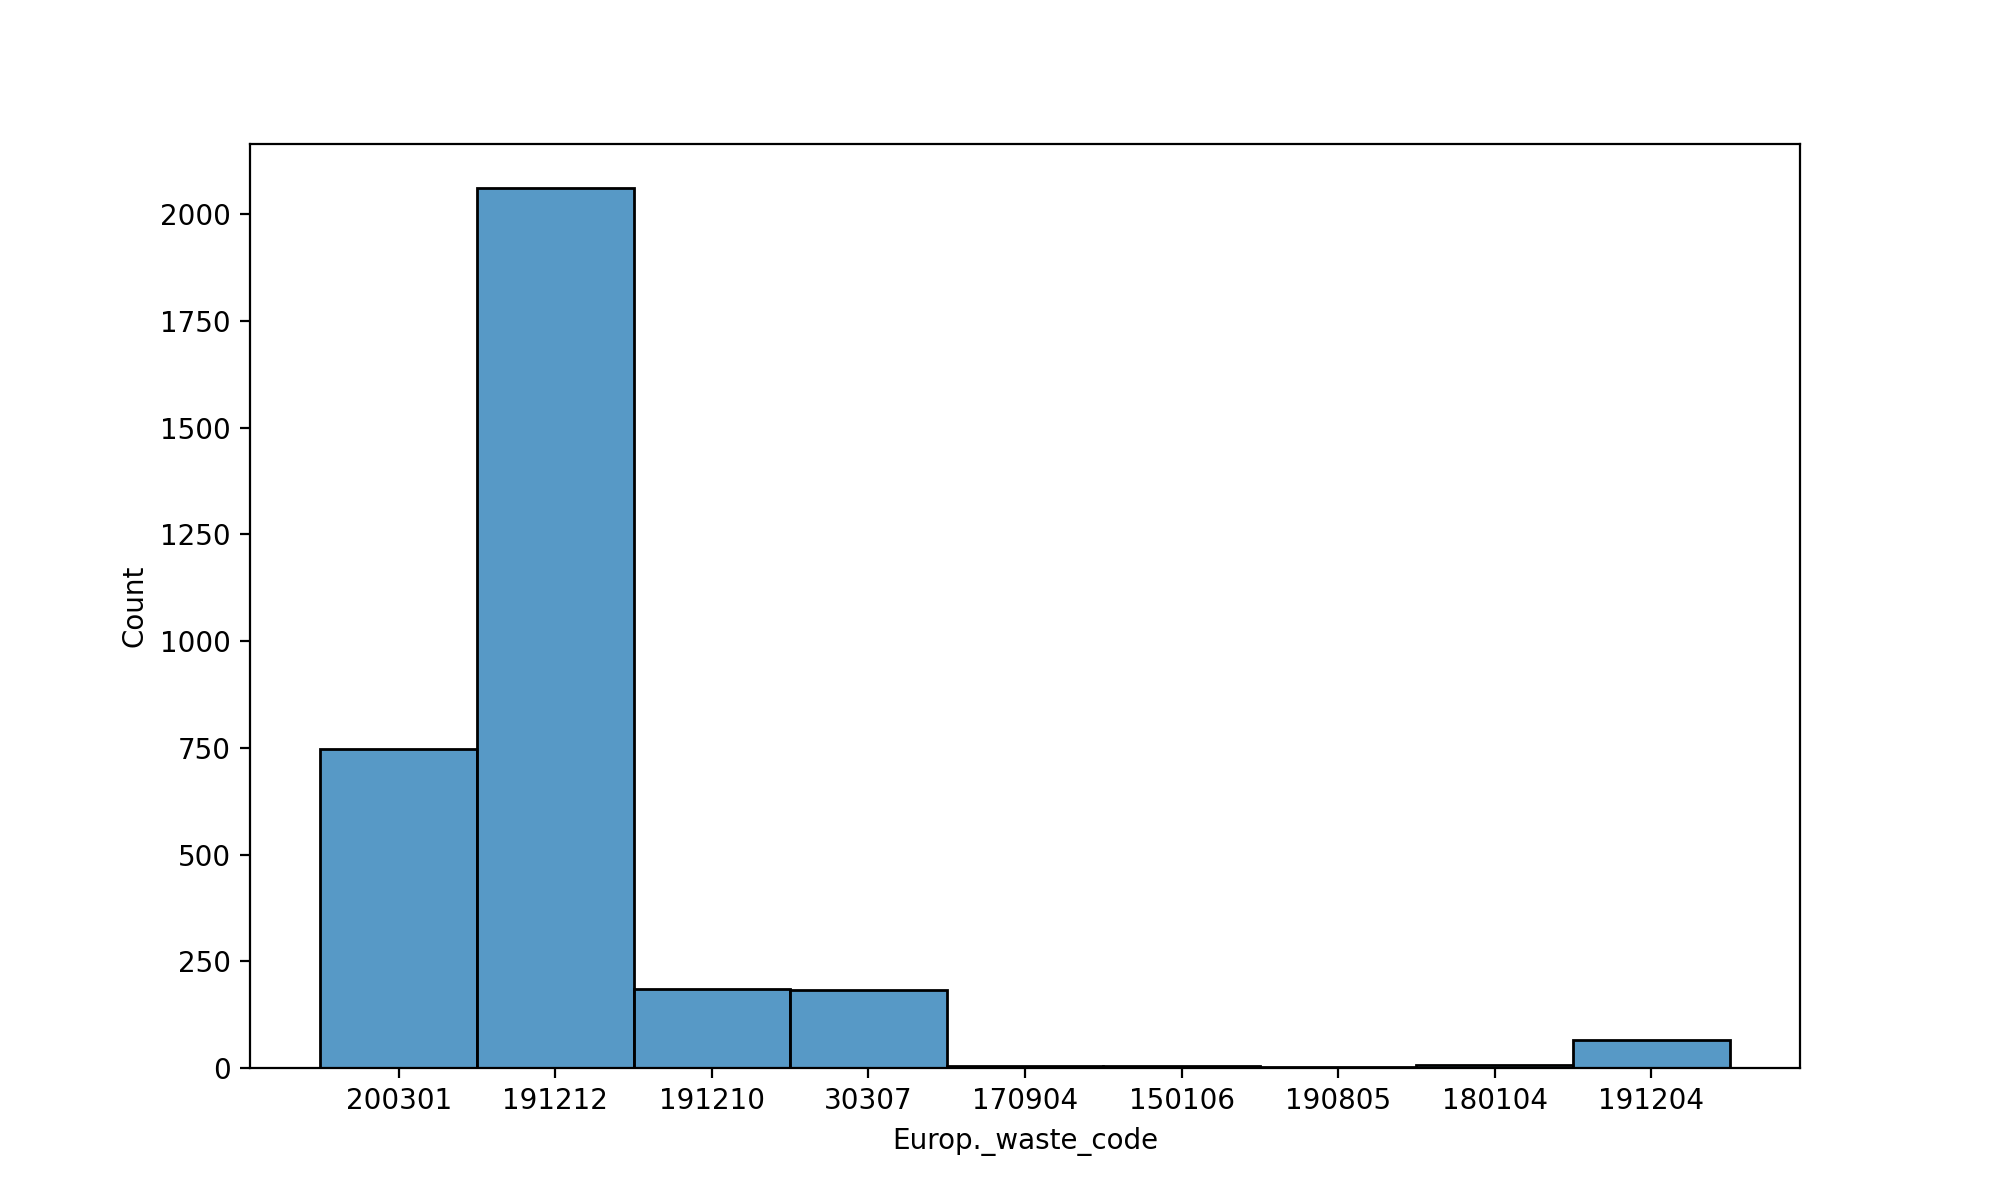

In [98]:
plt.figure(figsize=(10,6))
sns.histplot(df_sample['Europ._waste_code'])
plt.show()

### **Note:** We want to look at the wastes with waste code 191212 for futher analysis.

### Kmeans Clustering

In [67]:
df_sample_new = df_sample[df_sample['Europ._waste_code']=='191212']

X_sample = df_sample_new[[ 'contourness_std_std',
 'fall_direction_variation_abs',
 'blobness_abs',
 'homogeneity_std_std',
 'glcm_homogeneity_std',
 'glcm_contrast_std',
 'glcm_energy_std']]

In [43]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_sample)

In [44]:
from sklearn.cluster import KMeans

def get_within_cluster_dis(num_cluster):
    # run k-means clustering on the data and...
    kmeans = KMeans(n_clusters=num_cluster)
    model = kmeans.fit(X_scaled)
    
    # compute the average within-cluster distances.
    score = np.abs(model.score(X_scaled))
    
    return score

In [45]:
scores = []
num_clusters = np.arange(1, 16, 1)

for num_cluster in num_clusters:
    scores.append(get_within_cluster_dis(num_cluster))

<IPython.core.display.Javascript object>


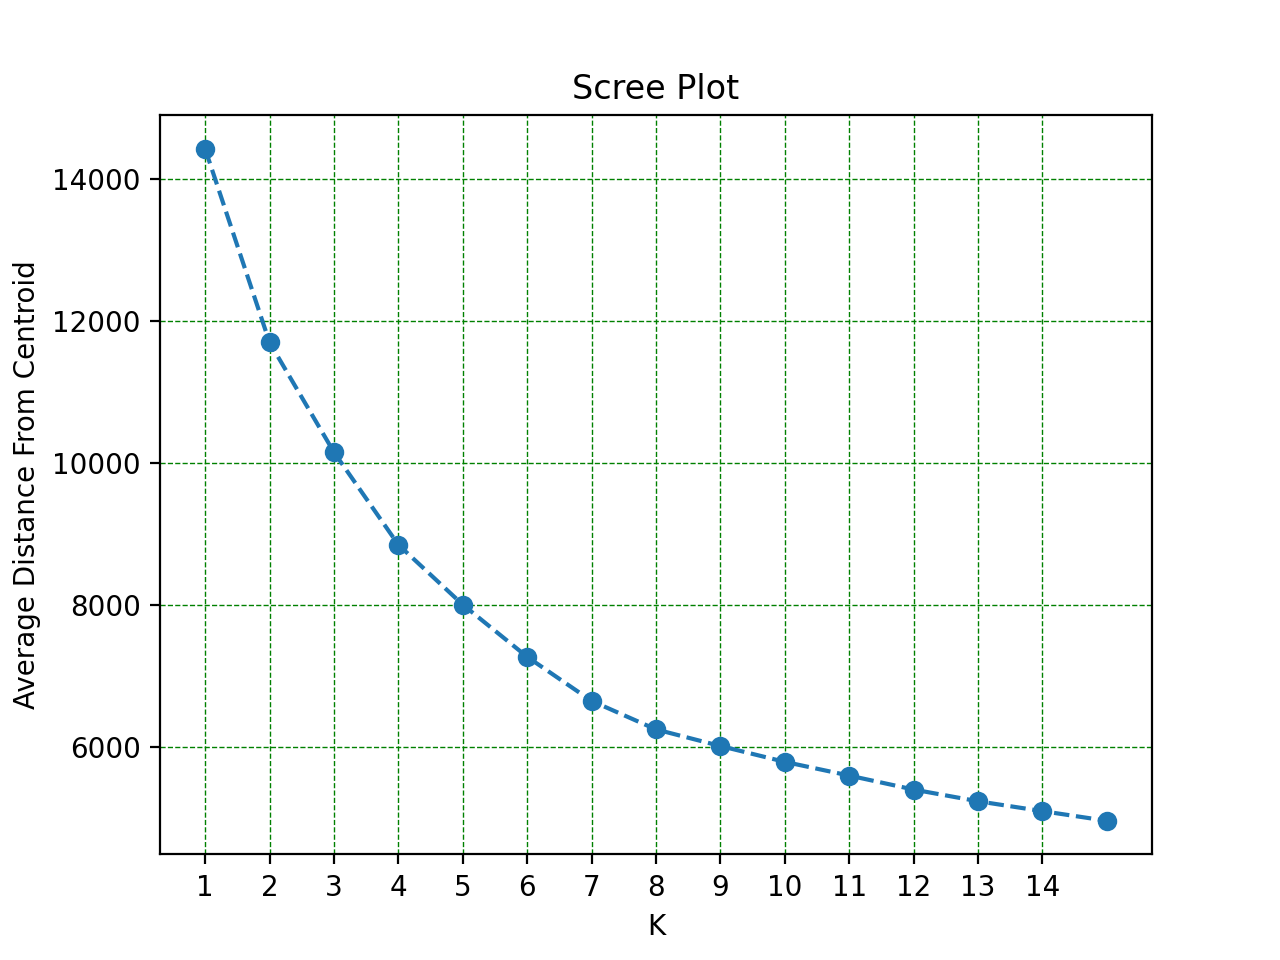

In [46]:
plt.plot(num_clusters, scores, linestyle='--', marker='o')
plt.xlabel('K')
plt.xticks(range(1,15))
plt.ylabel('Average Distance From Centroid')
plt.title('Scree Plot')
plt.grid(color = 'green', linestyle = '--', linewidth = 0.5)
plt.show()

In [48]:
# Re-fit the k-means model with the selected number of clusters

kmeans = KMeans(n_clusters=4, random_state=42)
model = kmeans.fit(X_sample)
pred_labels = model.predict(X_sample)

<IPython.core.display.Javascript object>


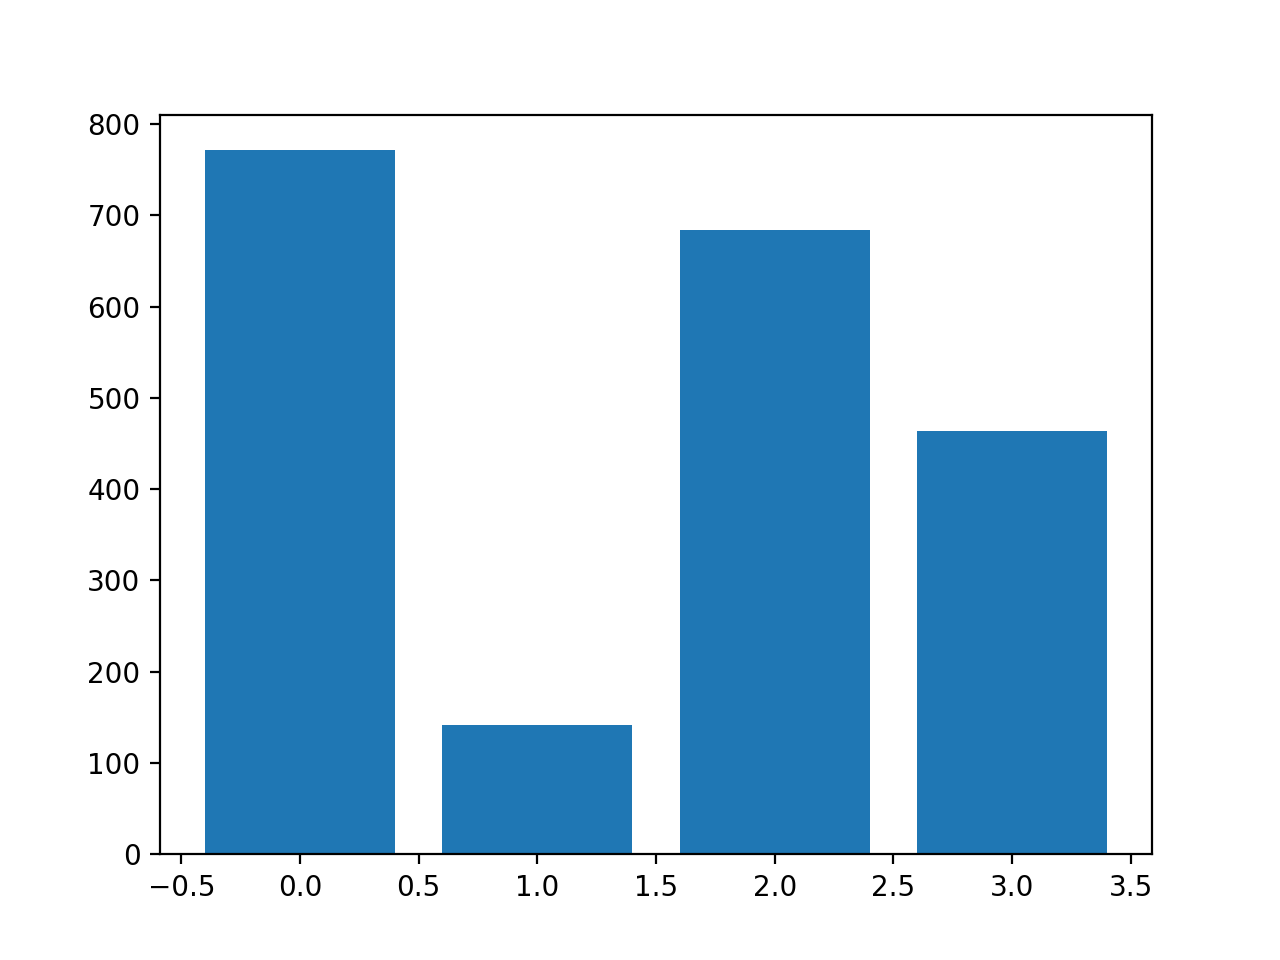

<BarContainer object of 4 artists>

In [66]:
count_dict = dict(Counter(pred_labels))
plt.bar(count_dict.keys(), count_dict.values())

In [69]:
df_sample_new['label'] = pred_labels

<ipython-input-69-e1f38c4453b3>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sample_new['label'] = pred_labels


<IPython.core.display.Javascript object>


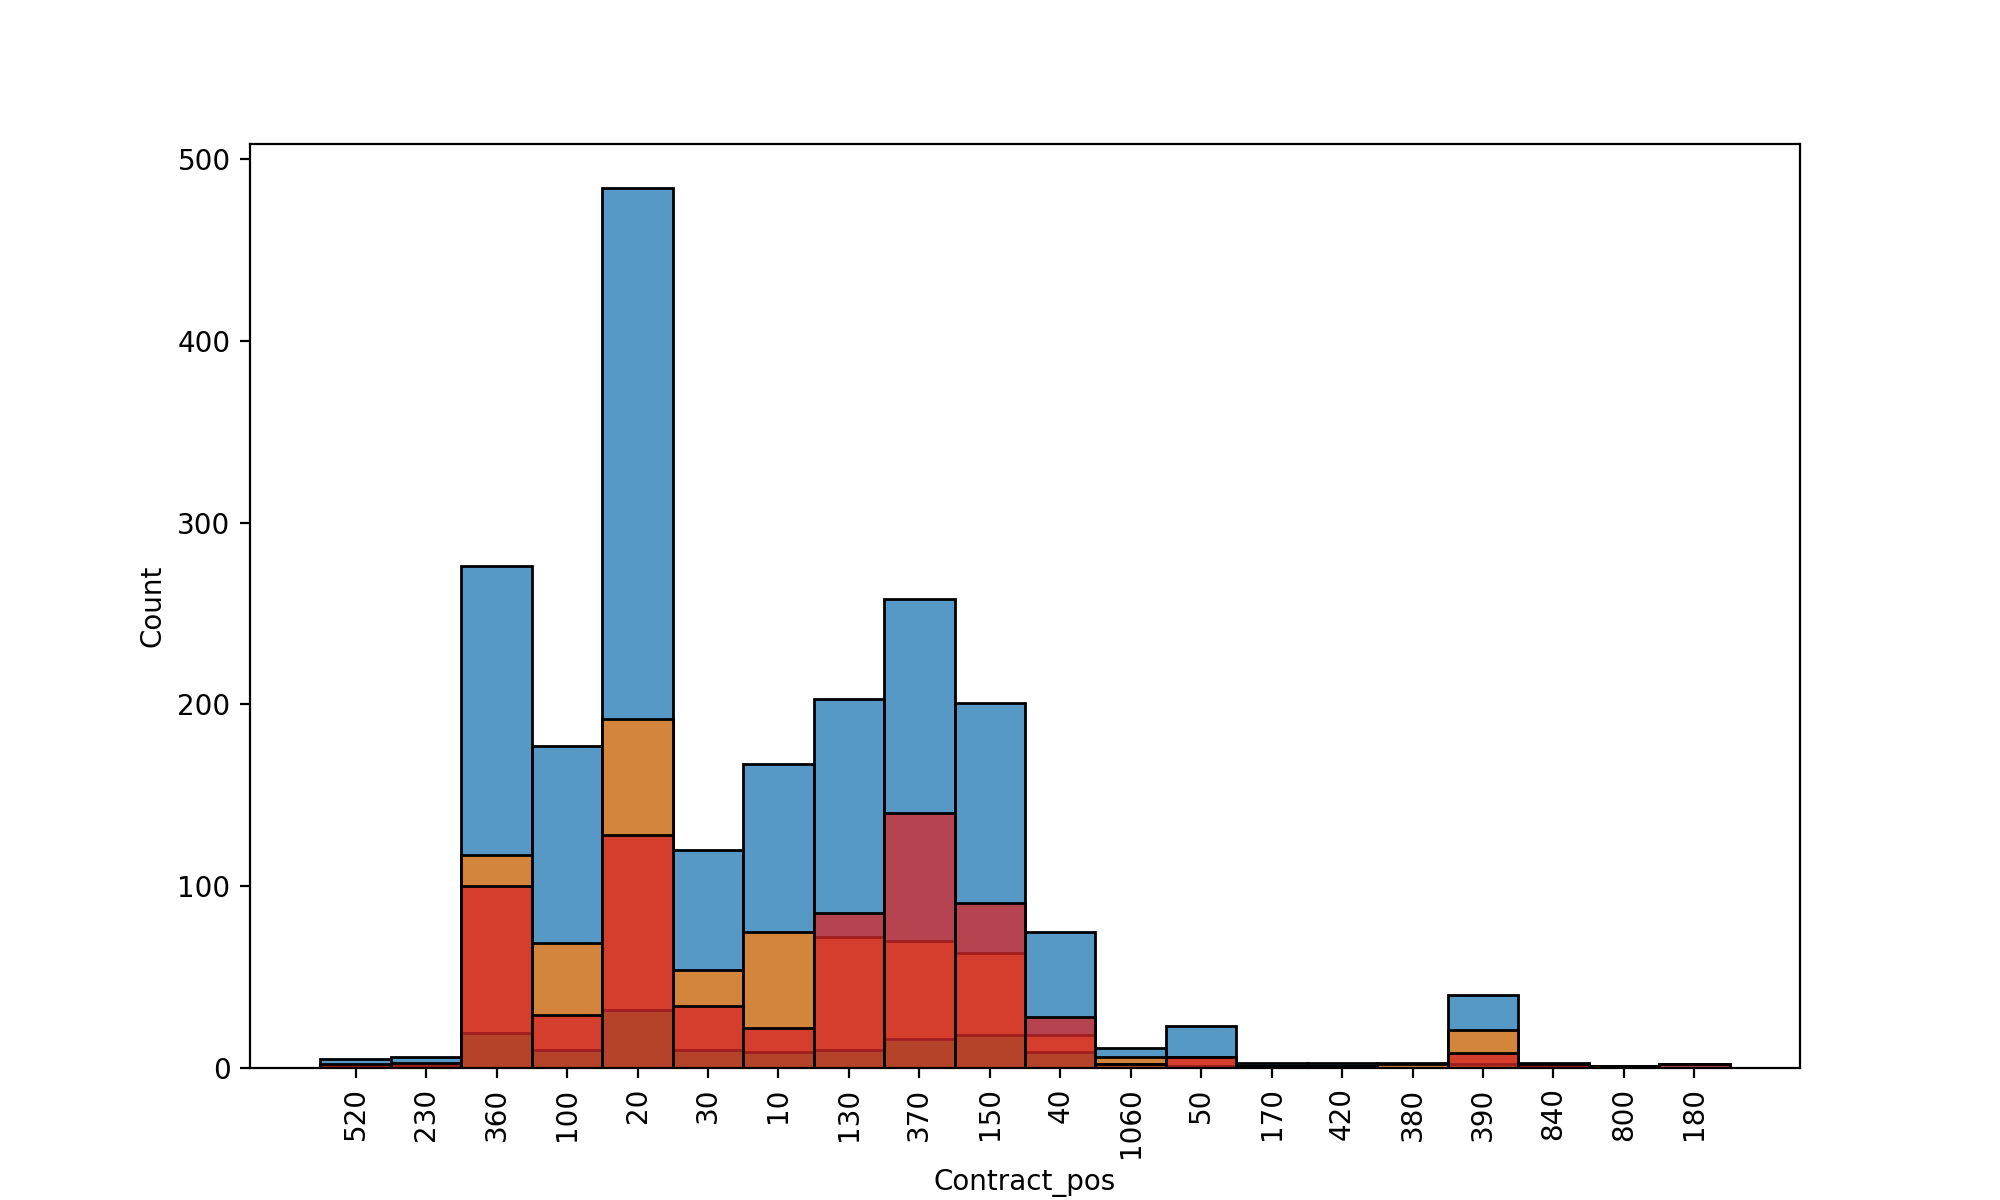

In [116]:
plt.figure(figsize=(10,6))
sns.histplot(df_sample_new['Contract_pos'])
sns.histplot(df_sample_new[df_sample_new.label==0]['Contract_pos'])
sns.histplot(df_sample_new[df_sample_new.label==1]['Contract_pos'])
sns.histplot(df_sample_new[df_sample_new.label==2]['Contract_pos'])

plt.xticks(rotation=90)
plt.show()

<IPython.core.display.Javascript object>


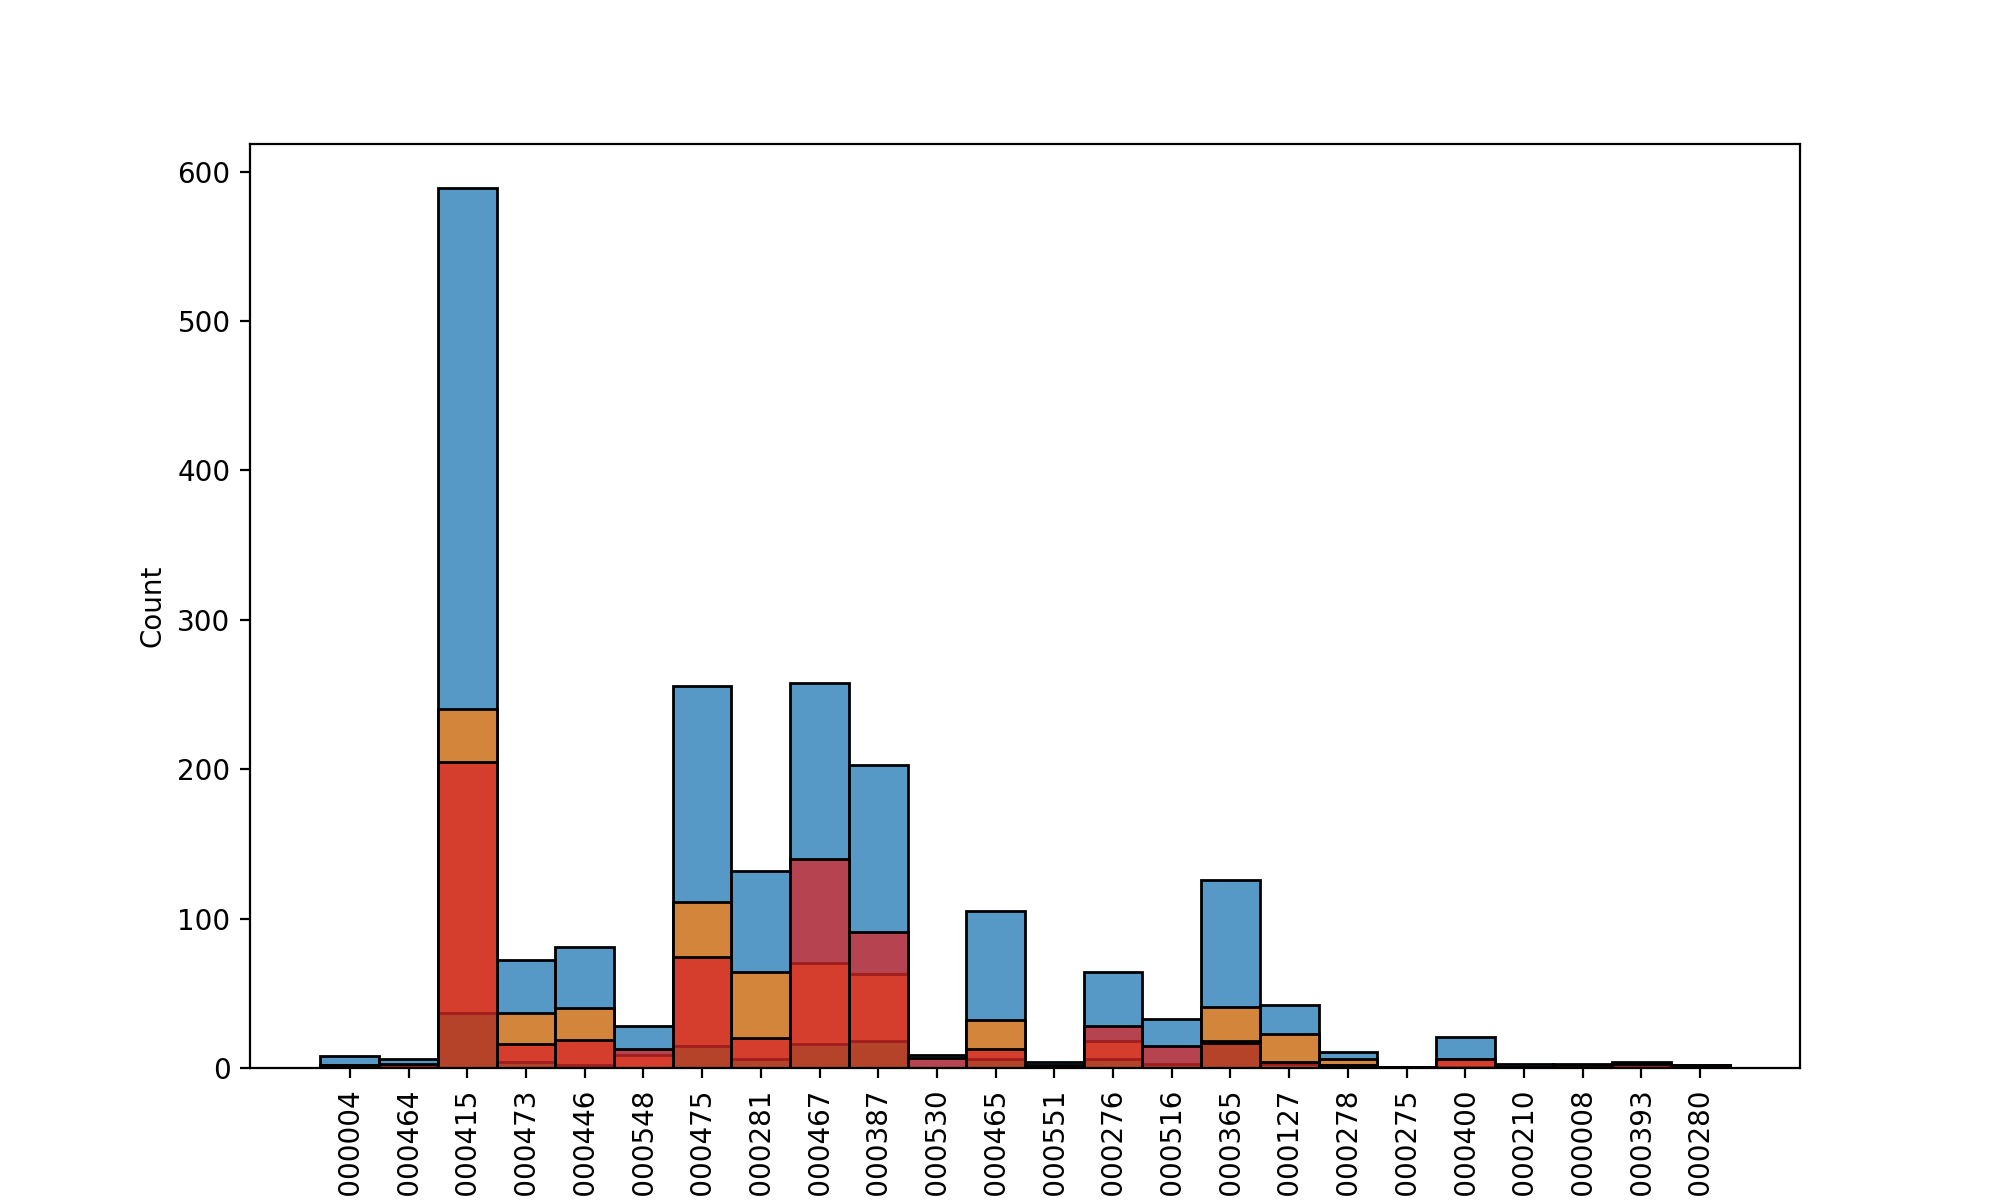

In [117]:
plt.figure(figsize=(10,6))
sns.histplot(df_sample_new['Contract_nb'])
sns.histplot(df_sample_new[df_sample_new.label==0]['Contract_nb'])
sns.histplot(df_sample_new[df_sample_new.label==1]['Contract_nb'])
sns.histplot(df_sample_new[df_sample_new.label==2]['Contract_nb'])

plt.xticks(rotation=90)
plt.show()

<IPython.core.display.Javascript object>


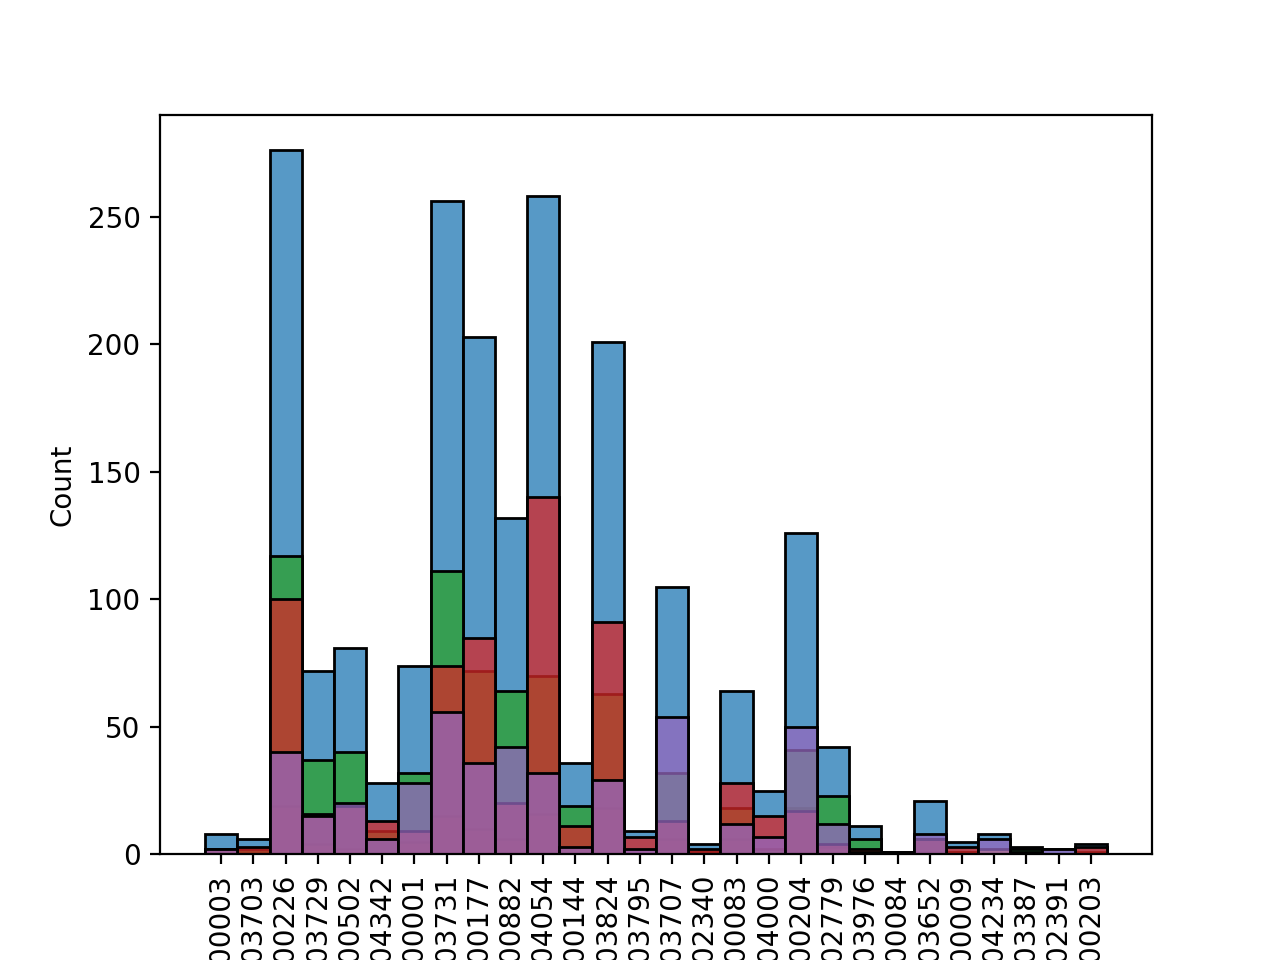

In [92]:
sns.histplot(df_sample_new['Source_company'])
plt.xticks(rotation=90)
plt.show()

In [118]:
tsne_result = pipeline.fit_transform(X_sample)
y =  df_sample_new['Contract_pos']

# Make dataframe from tnse result
tsne_result_df = pd.DataFrame({'tsne_1': tsne_result[:,0], 'tsne_2': tsne_result[:,1], 'code': y})

/Users/aliafs/opt/anaconda3/envs/general/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


<IPython.core.display.Javascript object>


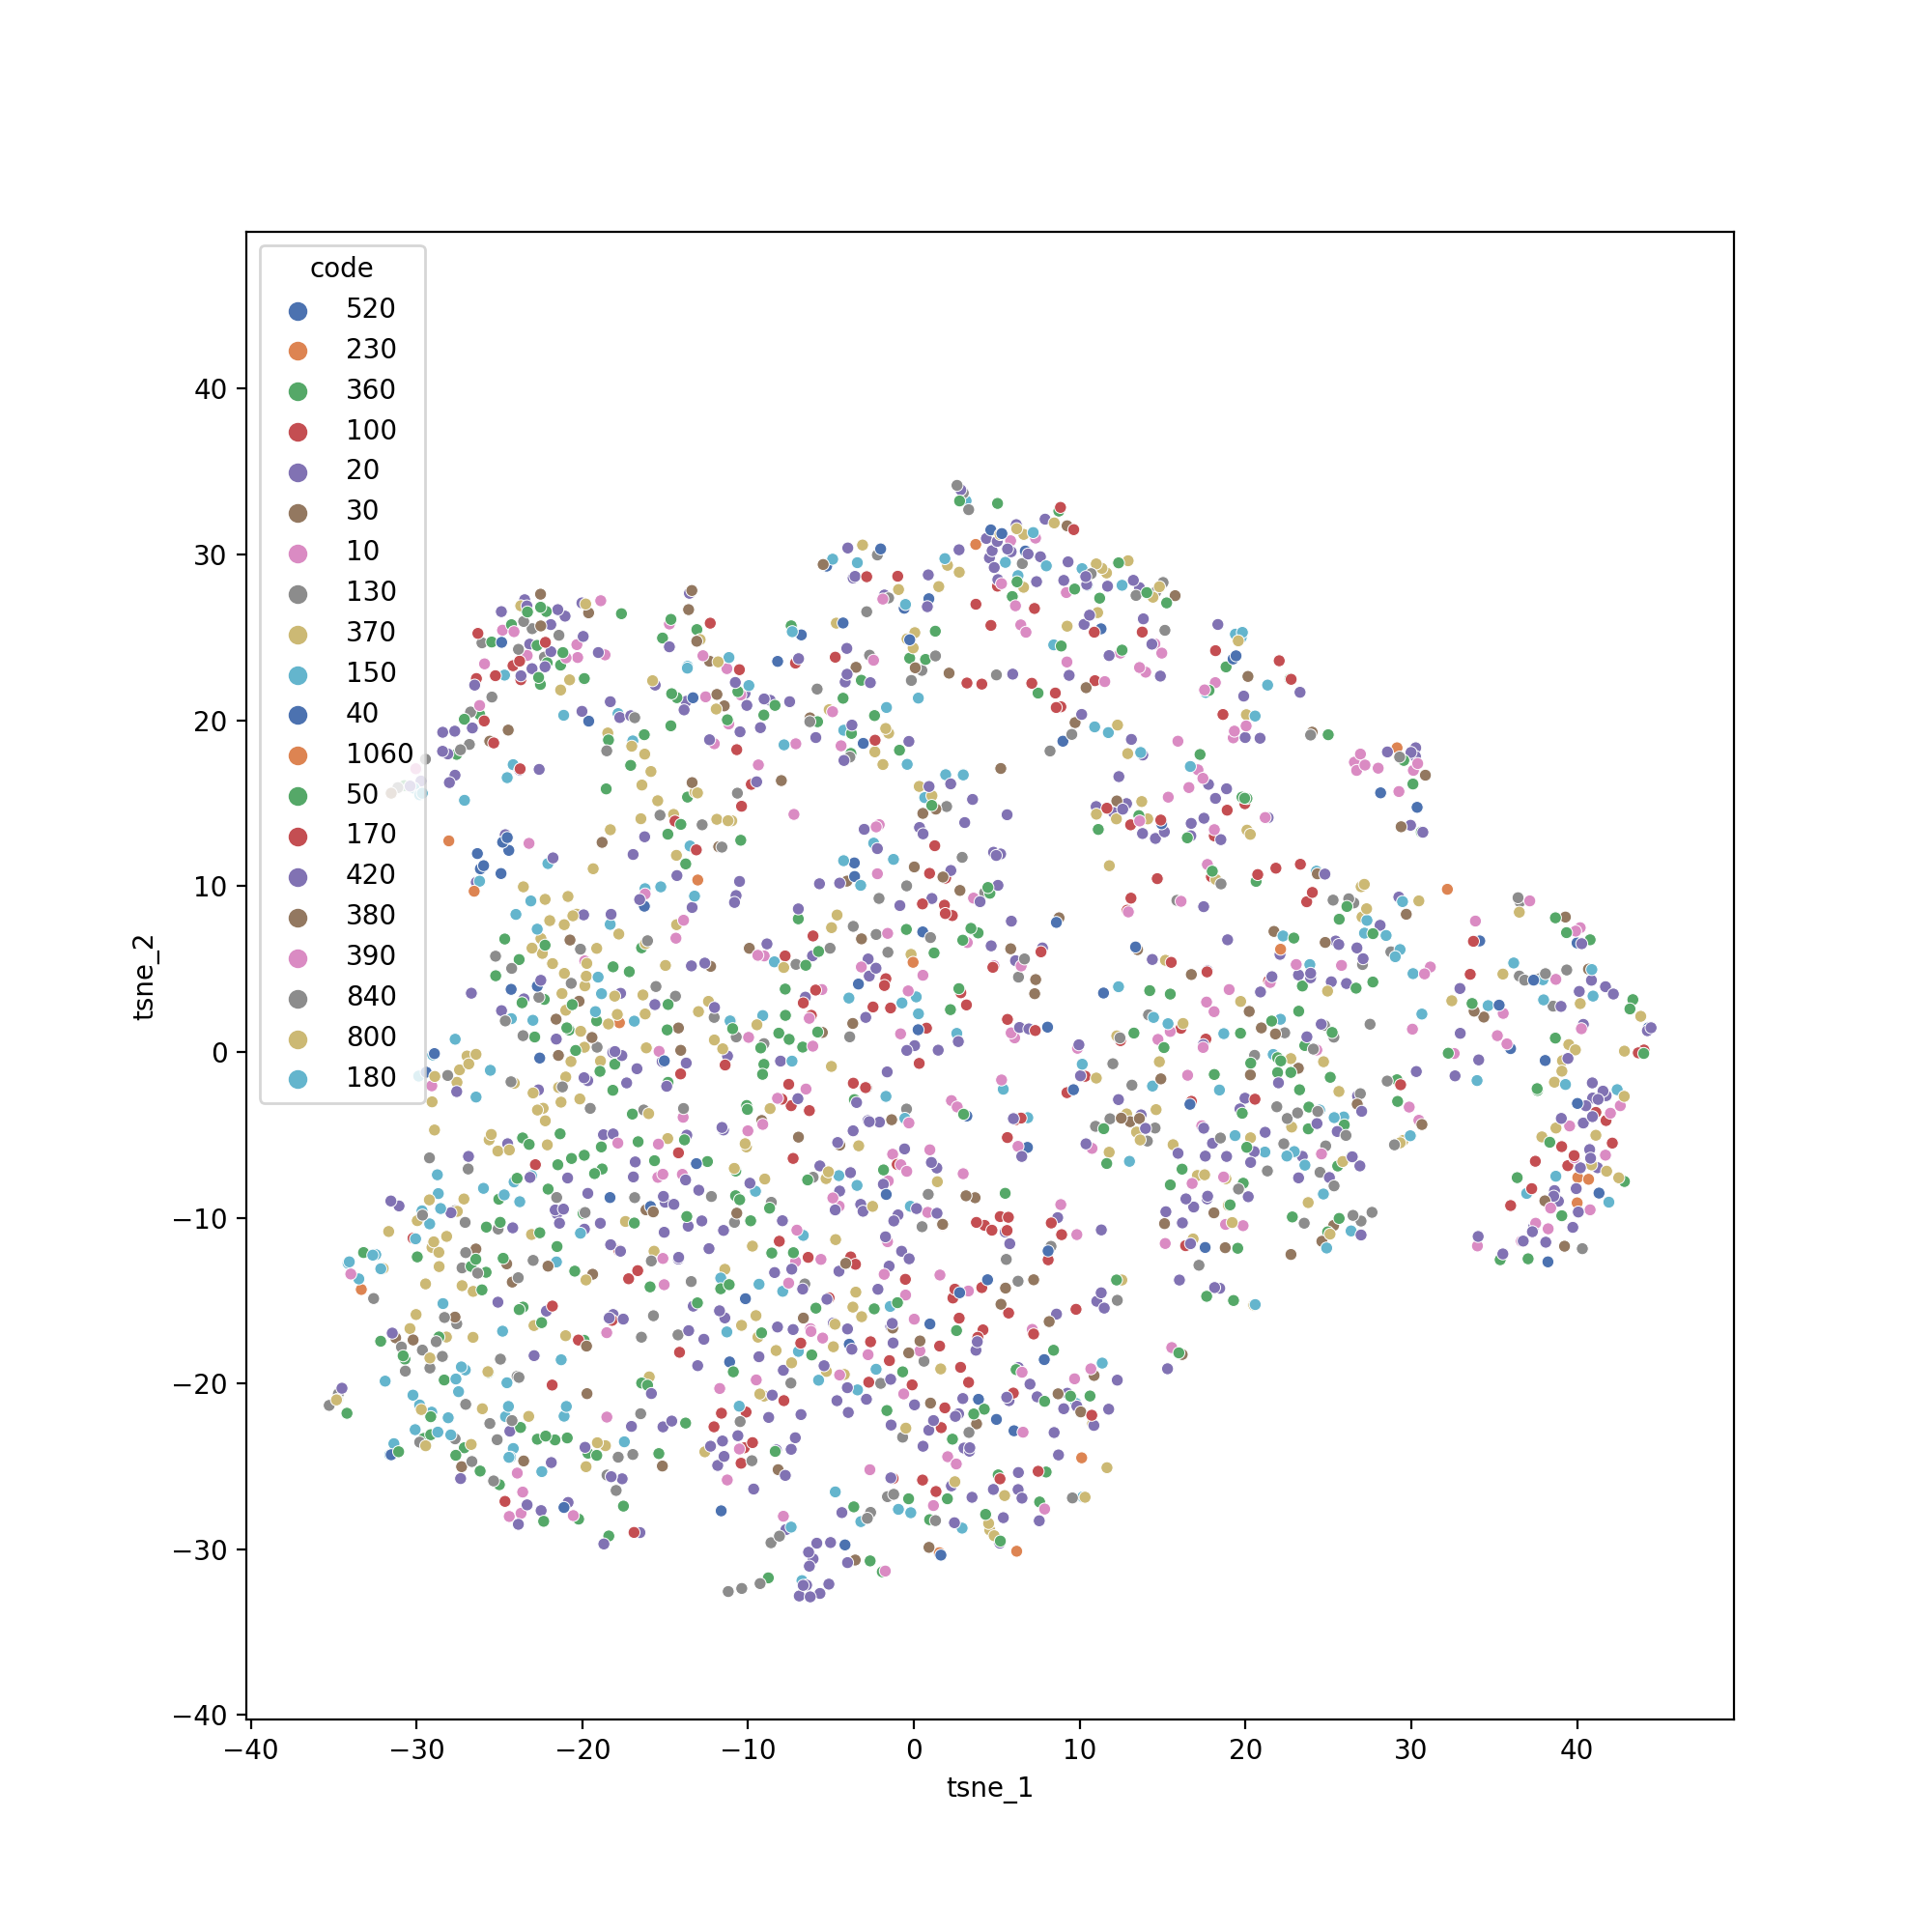

In [119]:
# Plot TSNE result
fig, ax = plt.subplots(1, figsize=(10, 10))
sns.scatterplot(x='tsne_1', y='tsne_2', data=tsne_result_df, ax=ax, s=20, hue='code', palette="deep")
lim = (tsne_result.min()-5, tsne_result.max()+5)
ax.set_xlim(lim)
ax.set_ylim(lim)
ax.set_aspect('equal')

bof (bag of feature):
    algorithm extract features from each images
   
    results:
        num_features (array size 24 --> 24 images in the delivery): number of features for each image
        pixle_codebook_feature
        img_codebook_feature (calculated for sequence of images)

**Note:** two different company could have same contract-pos but the wastes have not the same characteristics.
(contract-pos is just a number assign to each waste without meaning)

**Find outliers**
- look at the dense clusters on the tsne results (or other methods --> mybe they are outliers)
- we should combine the source_company, contract_pos, Eurpoean_waste_code 

glcm: giving a feature based on the texture


----

## For one source company

<IPython.core.display.Javascript object>


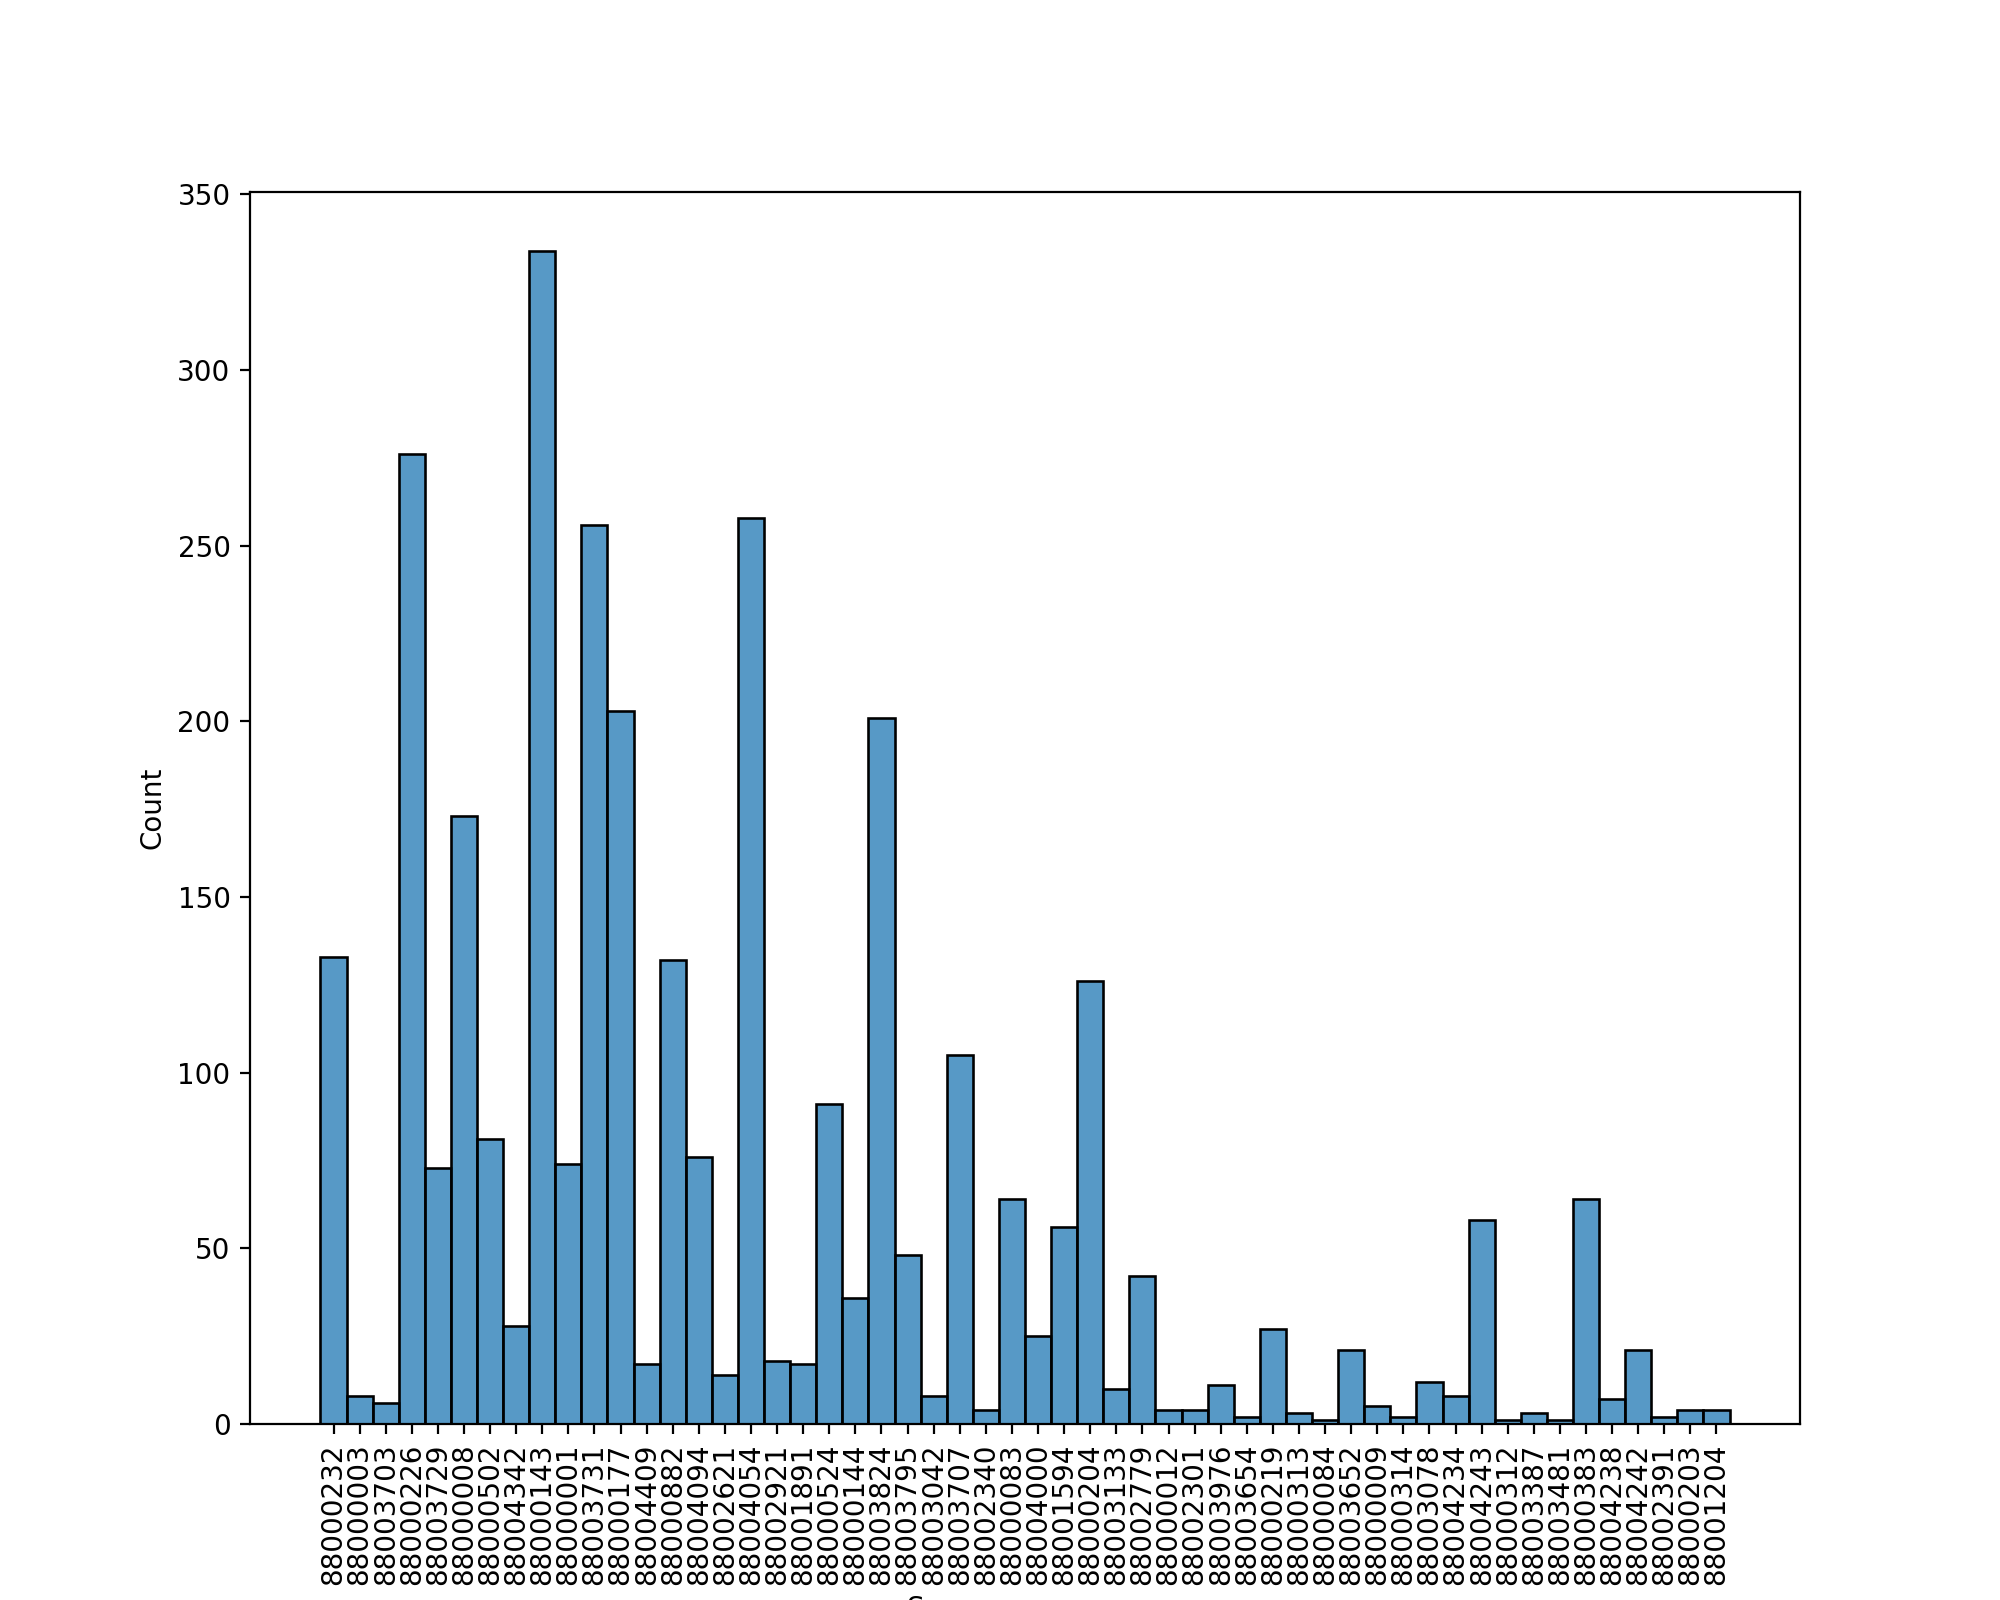

In [110]:
plt.figure(figsize=(10,8))
sns.histplot(df_sample['Source_company'])
plt.xticks(rotation=90)
plt.show()